# Test Notebook for functions in utilities

09/03/2022: tested with v0.6

In [1]:
%matplotlib inline
import os,sys,io 
import scipy.signal

from urllib.request import urlopen
from IPython.display import display, Audio, HTML, clear_output
from ipywidgets import interact

import math,time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 

    
import pyspch.sp as Sps
import pyspch.display as Spd
import pyspch.core as Spch

### CONFUSION MATRIX

The confusion matrix can be a numpy array or a pandas DataFrame

[[0.1 0.8 0.1]
 [0.2 0.3 0.5]
 [0.9 0.1 0. ]]


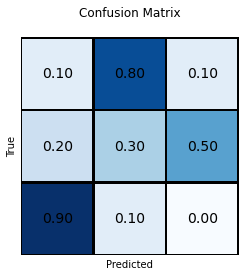

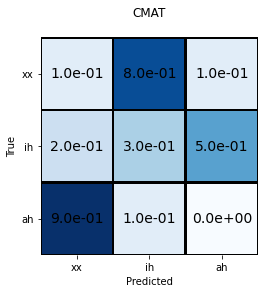

In [2]:
cm = np.array([[.1,.8,.1],[.2,.3,.5],[.9,.1,.0]])
labels=['xx','ih','ah']
print(cm)
Spch.plot_confusion_matrix(cm,fmt='.2f');
#
Spch.plot_confusion_matrix(cm,fmt='.1e',labels=labels,title='CMAT\n');


In [ ]:
# 
HAT1D = [
    [0.,1.,2.,1.,0.,0.1,-0.1,0.,.05],
    [0.,0.,0.,1.,2.,1.,0.,0.],
    [0.,1.5,2.5,1.,0.,0.15,-0.2,0.,.5],
    [0.5,0.2,0.1,.8,1.2,1.,-0.3,0.4]
]


def flatten(t):
    return [item for sublist in t for item in sublist]

def load_toy_data(data='seq1d',select=0):
    '''
    a number of toy data sets, intended for debugging
    
    Arguments:
    
    data (str):   the type of data to generate, options are
                      'seq1d', 'seq1d_d', 'seq2d', 'seq2d_d'
    select (int or slice):   a number for selecting a variant
    '''
    
    data = data.lower()
    
    if data == 'hat1d': dataset = HAT1D
    
    Y = []
    for x in dataset:
        Y.append(np.array(x))

    return(Y[select])

In [ ]:
sel = slice(0,3)
for i in range(sel.start,sel.stop): print(i)

In [ ]:
x1d = np.array([0.,1.,2.,1.,0.,0.1,-0.1,0.,.05]).reshape(-1,1)
y1d = np.array([0.,0.,0.,1.,2.,1.,0.,0.]).reshape(-1,1)
x2d = np.array([[0.,1.,2.,1.,0.,0.1,-0.1,0.,.05],[0.3,1.3,1.5,1.5,1.,0.3,-0.24,0.3,.05]]).T
y2d = np.array([[0.,0.,0.,1.,2.,1.,0.,0.],[1.,1.,1.,1.,-2.,-1.,0.3,0.5]]).T

In [ ]:
X = load_toy_data(data='hat1d',select=0)
X

In [ ]:
h1flat=flatten(HAT1D)
h1flat[0,3]

## TIMIT Alphabets, Mappings, label2indx, ..

we use following naming conventions

- phone:  name of an element in a phonetic alphabet
- idx:    index of a phone in the alphabet
- map_phn2idx, map_idx2phn:  dictionaries for converting between phone and idx
- seg:    segmentation dataframe
- lbls:   (list) alignment sequence of phone labels
- indx:   (list) alignment sequence of phone indices

In [ ]:
### Predefined symbol sets , e.g. TIMIT61, TIMIT48, TIMIT41
Spch.TIMIT41

In [ ]:
# predefined conversions
Spch.timit61_41

In [ ]:
# unique phone <--> index mappings
phn_set = np.array(Spch.TIMIT41)
map_idx2phn = {i : phn for i, phn in enumerate(phn_set) }
map_phn2idx = {phn : i for i, phn in enumerate(phn_set) }
map_idx2phn

In [ ]:
# convert labels to indices usable for slicing
def lbls2indx(lbls,map_phn2idx=None):
    return np.array([ map_phn2idx[phn] for phn in lbls ])
# convert indices to labels for readability
def indx2lbls(indx,map_idx2phn=None):
    return np.array([ map_idx2phn[i] for i in indx ])

In [ ]:
indx = [0,3,38,2,2,2,1]
lbls = indx2lbls(indx,map_idx2phn=map_idx2phn)
lbls

In [ ]:
indxx = lbls2indx(lbls,map_phn2idx=map_phn2idx)
indxx

## Segmentations and Alignments

- segmentation:  contains asynchronous segmentation times and labels
- alignment:     a frame synchronous mapping from index to label

In [ ]:
# convert a segmentation in DataFrame format to a label sequence
def seg2lbls(seg,shift=0.01,output=None,indices=False):
    '''
    Convert segmentation dataframe to a label sequence
    
    Arguments:
        indices    Boolean, False returns the labels only, True returns indices+labels
        output     'df' will return as DataFrame, otherwise as array
        
    Returns 
        zip of (frame_indices, frame_labels)
        dataframe of (frame_indices, frame_labels) if output == 'df' 
    
    if indices=False, then the index of the returned alignment can be used as frame label
        This assumes the segmentation to be 'complete', i.e. no missing gaps
    if indices=True, then the segmentation needs not be complete, some frame indices may be missing

    '''
    fr_indx = []
    lbls = []
    for indx in seg.index:
        i1 = round((seg['t0'][indx])/shift)
        i2 = round(seg['t1'][indx]/shift)
        for i in range(i1,i2):
            fr_indx.append(i)
            lbls.append(seg['seg'][indx])
    fr_indx = np.array(fr_indx)
    lbls = np.array(lbls)
    if indices:
        if output == 'df':
            return(pd.DataFrame({"frame":fr_indx,"label":lbls}))
        else:
            return(zip(fr_indx,lbls))
    else:
        if output == 'df':
            return(pd.DataFrame({"label":lbls}))
        else: return(lbls)

        
        
def lbls2seg(lbls,shift=0.01):
    '''
    convert a label sequence to a segmentation DataFrame
    This conversion may fail if some frames are not labeled
    '''

    t1 = []
    t0 = [ 0. ]
    seg = [ lbls[0] ]
    for i in range(1,len(lbls)):
        if lbls[i] != lbls[i-1]:
            t0.append( i*shift )
            seg.append(lbls[i])
            t1.append( i*shift )
    t1.append( len(lbls) * shift )
    return( pd.DataFrame({'t0':t0,'t1':t1,'seg':seg}) )    


In [ ]:
# read a datafile
dir='https://homes.esat.kuleuven.be/~spchlab/data/'
file = "timit/si1027" 
sr=16000.
segphn = Spch.read_seg_file(dir+file+ ".phn",dt=1/sr,fmt='float32',xlat='timit61_41')
segphn

In [ ]:
seg2lbls(segphn,output='df')

In [ ]:
seg2lbls(segphn)

### Reading TIMIT transcriptions files

In [ ]:
fn1 = 'timit/sa1.txt'
#fn1="timit/phones-61-48-39-41.txt"
fname='https://homes.esat.kuleuven.be/~spchlab/data/'
transcript = Spch.read_data_file(fname+fn1)[0].strip().split(None,2)
print('Samples: ',int(transcript[0]),int(transcript[1]))
print('Transcript: ',transcript[2].strip('.,!?:;'))

### Reading Mapping files and converting to dictionary

In [ ]:
fn1="timit/phones-61-48-39-41.txt"
fname='https://homes.esat.kuleuven.be/~spchlab/data/'
transcript = Spch.read_data_file(fname+fn1)
cols = Spch.read_data_file(fname+fn1, maxcols = 4)
dict(zip(cols[0],cols[3]))

## (TIMIT) Segmentation Files

Segmentation Files are assumed to be in the format

t0  t1   seg    
....


#### time units
t0, t1 are begin and end-times of segment 'seg'
the units of time, can be specified in the read_seg_file() module with 'dt', by default segmentation times are given in seconds;
in timit it is often in samples (with SR=16000), thus use dt=1/16000

#### phonetic symbols
Phonetic transcriptions come in a variety of phonetic symbol sets.
These utilities include default definitions (and orderings) of **TIMIT48** and **TIMIT41**.   TIMIT48 is the default used in experiments with TIMIT.   TIMIT41 is our own more compact version inspired by the alphabet in the CMU dictionaries, with 1 additional closure ('cl') symbol.

A number of mappings between the different alphabets are foreseen.  To apply them use the field 'xlat' at time of reading and specify the desired translation:  timit61_48, timit61_41, ..
These are simple dictionary based mappings.   

In [ ]:
# read a datafile
dir='https://homes.esat.kuleuven.be/~spchlab/data/'
file = "timit/si1027" #@param {type:"string"}
wavfile = dir+file+".wav" 
wavdata, sr = Spch.load(wavfile)
spg1 = Sps.spectrogram(wavdata,sample_rate=sr,n_mels=None)

# get segmentations
segwrd = Spch.read_seg_file(dir+file+ ".wrd",dt=1/sr,fmt='float32')
segphn61 = Spch.read_seg_file(dir+file+ ".phn",dt=1/sr,fmt='float32')
segphn = Spch.read_seg_file(dir+file+ ".phn",dt=1/sr,fmt='float32',xlat='timit61_41')

In [ ]:
fig = Spd.PlotSpg(spg1,wavdata=wavdata,segwav=segwrd,segspg=segphn,sample_rate=sr)
display(fig)
display(Audio(data=wavdata,rate=sr))